In [30]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, LSTM, RNN,GRU,Dropout
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from scipy import stats
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.callbacks import TensorBoard
import datetime
from tensorflow.keras import regularizers
import visualkeras


In [17]:
additional_metrics = ['accuracy']
batch_size = 64
loss_function = categorical_crossentropy
number_of_epochs = 25
optimizer = Adam()
validation_split = 0.20
verbosity_mode = 1

['Walking' 'Shaking' 'Sniffing' 'Eating' 'Sitting' 'Trotting' 'Pacing'
 'Lying chest' 'Playing' 'Standing' 'Panting' 'Drinking' 'Galloping'
 'Carrying object' 'Tugging' 'Jumping' 'Bowing']


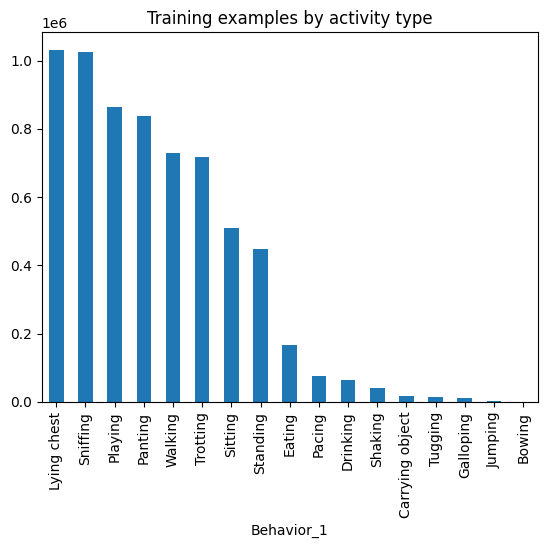

In [18]:
data=pd.read_csv("DogMoveData.csv",memory_map=True)
data=data.dropna()
data = data.drop(data[data['Behavior_1'] == '<undefined>'].index)
data=data.drop(data[data['Behavior_1'] == 'Synchronization'].index)
data=data.drop(data[data['Behavior_1'] == 'Extra_Synchronization'].index)
#view updated DataFrame
data=data.drop(['Behavior_2','Behavior_3','PointEvent'],axis=1)
print(data['Behavior_1'].unique())
l=data['Behavior_1'].unique()
data['Behavior_1'].value_counts().plot(kind='bar', title='Training examples by activity type');

In [19]:
# Creating a instance of label Encoder.
le = LabelEncoder()
 
# Using .fit_transform function to fit label
# encoder and return encoded label
label = le.fit_transform(data['Behavior_1'])
 
# printing label
label
data.drop("Behavior_1", axis=1, inplace=True)
 
# Appending the array to our dataFrame
# with column name 'Purchased'
data["Behavior_1"] = label

In [20]:
N_TIME_STEPS = 70
N_FEATURES = 12
step = 20
segments = []
labels = []
for i in range(0, len(data) - N_TIME_STEPS, step):
    x1 = data['ABack_x'].values[i: i + N_TIME_STEPS]
    y1 = data['ABack_y'].values[i: i + N_TIME_STEPS]
    z1 = data['ABack_z'].values[i: i + N_TIME_STEPS]
    x2 = data['ANeck_x'].values[i: i + N_TIME_STEPS]
    y2 = data['ANeck_y'].values[i: i + N_TIME_STEPS]
    z2 = data['ANeck_z'].values[i: i + N_TIME_STEPS]
    x3 = data['GBack_x'].values[i: i + N_TIME_STEPS]
    y3 = data['GBack_y'].values[i: i + N_TIME_STEPS]
    z3 = data['GBack_z'].values[i: i + N_TIME_STEPS]
    x4 = data['GNeck_x'].values[i: i + N_TIME_STEPS]
    y4 = data['GNeck_y'].values[i: i + N_TIME_STEPS]
    z4 = data['GNeck_z'].values[i: i + N_TIME_STEPS]

    label = stats.mode(data['Behavior_1'][i: i + N_TIME_STEPS])[0][0]
    segments.append([x1, y1, z1,x2, y2, z2,x3, y3, z3,x4, y4, z4])
    labels.append(label)

C:\Users\karee\AppData\Local\Temp\ipykernel_13968\1107013484.py:20: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  label = stats.mode(data['Behavior_1'][i: i + N_TIME_STEPS])[0][0]


In [21]:
reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)
labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)

In [31]:

X_train, X_test, y_train, y_test = train_test_split(reshaped_segments, labels, test_size=0.3,shuffle=False)

In [23]:
reshaped_segments.shape

(327838, 70, 12)

In [9]:
X_train.shape

(229486, 70, 12)

In [24]:
model = Sequential()
model.add(LSTM(units=128, input_shape=(N_TIME_STEPS, N_FEATURES), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(units=17, activation='softmax'))

In [25]:
model.compile(optimizer=optimizer, loss=loss_function, metrics=additional_metrics)

In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 70, 128)           72192     
                                                                 
 dropout_3 (Dropout)         (None, 70, 128)           0         
                                                                 
 lstm_4 (LSTM)               (None, 70, 64)            49408     
                                                                 
 dropout_4 (Dropout)         (None, 70, 64)            0         
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 128)              

In [ ]:
log_dir = "logs/fit/LSTM" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [14]:
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=number_of_epochs, verbose=verbosity_mode, validation_split=validation_split,callbacks=[tensorboard_callback])

Epoch 1/25
2869/2869 [==============================] - 107s 34ms/step - loss: 0.9724 - accuracy: 0.6271 - val_loss: 0.6829 - val_accuracy: 0.7602
Epoch 2/25
2869/2869 [==============================] - 99s 34ms/step - loss: 0.6264 - accuracy: 0.7754 - val_loss: 0.5523 - val_accuracy: 0.8057
Epoch 3/25
2869/2869 [==============================] - 100s 35ms/step - loss: 0.5277 - accuracy: 0.8175 - val_loss: 0.4657 - val_accuracy: 0.8389
Epoch 4/25
2869/2869 [==============================] - 97s 34ms/step - loss: 0.4729 - accuracy: 0.8387 - val_loss: 0.4216 - val_accuracy: 0.8580
Epoch 5/25
2869/2869 [==============================] - 95s 33ms/step - loss: 0.4298 - accuracy: 0.8554 - val_loss: 0.3918 - val_accuracy: 0.8713
Epoch 6/25
2869/2869 [==============================] - 94s 33ms/step - loss: 0.4034 - accuracy: 0.8657 - val_loss: 0.3709 - val_accuracy: 0.8784
Epoch 7/25
2869/2869 [==============================] - 101s 35ms/step - loss: 0.3806 - accuracy: 0.8733 - val_loss: 0.361

In [15]:
%tensorboard --logdir=data/ --host localhost --port 8888


UsageError: Line magic function `%tensorboard` not found.


In [16]:
test_results = model.evaluate(X_test, y_test, verbose=False)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {100*test_results[1]}%')
model.save("LSTMFINALmodel")


Test results - Loss: 0.2934678792953491 - Accuracy: 90.67736268043518%


INFO:tensorflow:Assets written to: LSTMFINALmodel\assets


INFO:tensorflow:Assets written to: LSTMFINALmodel\assets


3074/3074 [==============================] - 33s 10ms/step
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(17, 17)
CSV file has been written successfully.


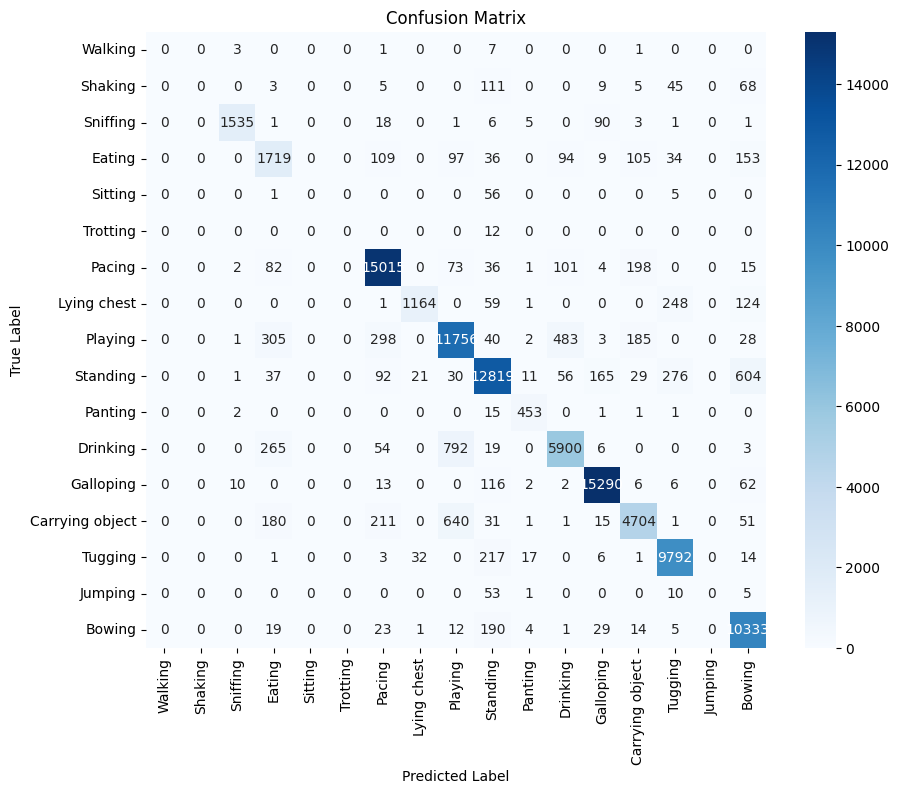

In [34]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import csv

rmodel=load_model("LSTMFINALmodel")
y_pred = np.argmax(rmodel.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
print(y_test)
cm = confusion_matrix(y_true, y_pred)
print(cm.shape)
data = list(zip(y_true, y_pred))

# Define the filename for the CSV file
filename = "predictions.csv"

# Write the data to the CSV file
with open(filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['y_true', 'y_pred'])  # Write header
    writer.writerows(data)  # Write the data rows

print("CSV file has been written successfully.")
cm_df = pd.DataFrame(cm, columns=l, index=l)

# Plot the confusion matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [29]:
# Calculate precision score
precision = precision_score(y_true, y_pred,average='macro')*100

# Calculate recall
recall = recall_score(y_true, y_pred,average='macro')*100

# Calculate F1 score
f1 = f1_score(y_true, y_pred,average='macro')*100

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)*100


print(precision)
print(recall)
print(f1)
print(accuracy)

63.23867132689808
62.254579579365576
62.61087452999921
91.82731413697739


C:\Users\karee\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
